Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


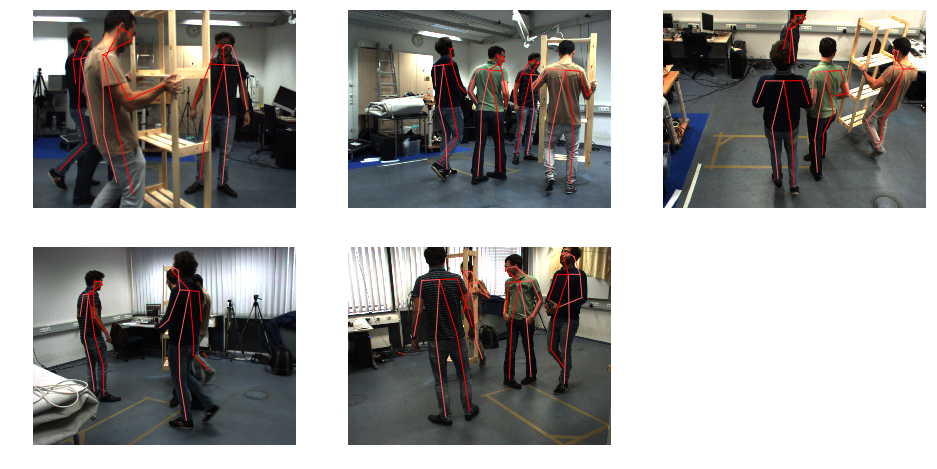

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import shelf
from time import time

root = join(Settings['data_root'], 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

from openpose import OpenPose

FRAME = 530
#FRAME = 416
pe = OpenPose(tmp=tmp)
Im, Y, Calib = shelf.get(root, FRAME)
predictions = pe.predict(Im, 'cvpr_shelf', FRAME)



fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red')

plt.show()

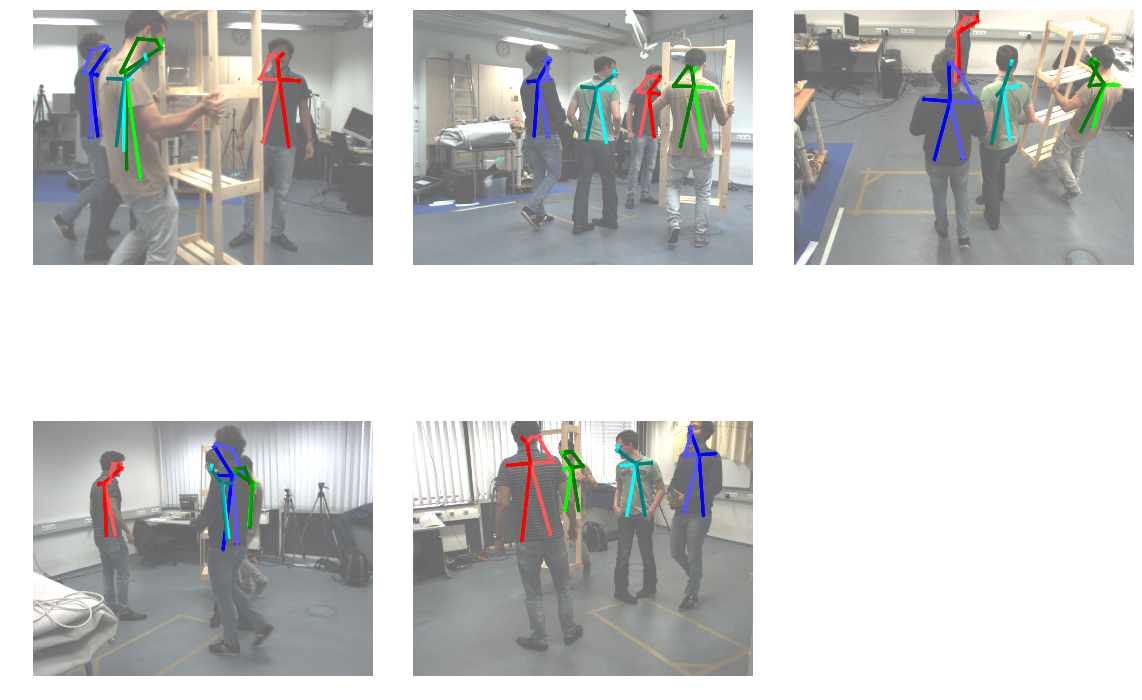

In [2]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, predictions)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'teal']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
# =====================================================
def proper_pcp_calc(Y, Humans):
    alpha = 0.5
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs


# def generate_pcp_score(frame):
#     Im, Y, Calib = shelf.get(root, frame)
#     predictions = pe.predict(Im, 'cvpr_shelf', frame)
    
#     # -- reduce #cams
# #     Calib = Calib[0:3]
# #     Y = Y[0:3]
# #     predictions = predictions[0:3]
#     # --------------
    
#     detections = estimate(Calib, predictions,
#                           epi_threshold=80)
#     Humans = kth.transform3d_from_mscoco(detections)
#     return proper_pcp_calc(Y, Humans) 

# =====================================================

valid_frames = list(range(300, 600))
# valid_frames = list(range(300, 310))

Calib = []
poses_per_frame = []
Pos3d = {}

_start = time()
for frame in valid_frames:
    Im, Y, calib = shelf.get(root, frame)
    Calib.append(calib)
    Pos3d[frame] = Y
    predictions = pe.predict(Im, 'cvpr_shelf', frame)
    poses_per_frame.append(predictions)
_end = time()
print('elapsed', _end - _start)

# PER_GTID = {}

# for frame in valid_frames:
#     _start = time()
    
#     L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = generate_pcp_score(frame)
#     if len(L_Arms) > 0:
#         for gtid, larms, uarms, llegs, ulegs in zip(
#             GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
#         ):
#             if not gtid in PER_GTID:
#                 PER_GTID[gtid] = {
#                     'larms': [],
#                     'uarms': [],
#                     'llegs': [],
#                     'ulegs': [],
#                     'frame': []
#                 }
#             PER_GTID[gtid]['larms'].append(larms)
#             PER_GTID[gtid]['uarms'].append(uarms)
#             PER_GTID[gtid]['llegs'].append(llegs)
#             PER_GTID[gtid]['ulegs'].append(ulegs)
#             PER_GTID[gtid]['frame'].append(frame)
    
    
#     _end = time()
#     print('frame ' + str(frame) + ', elapsed:', _end - _start)

elapsed 70.44197821617126


In [4]:
from mvpose.baseline.tracking import tracking, Track

_start = time()
tracks = tracking(Calib, poses_per_frame,
                  epi_threshold=80,
                  scale_to_mm=1000,
                  max_distance_between_tracks=200,
                  actual_frames=valid_frames,
                  min_track_length=10,
                  merge_distance=80,
                  last_seen_delay=15)
_end = time()
print('elapsed', _end - _start)

print("#tracks", len(tracks))

for track in tracks:
    print(len(track))

elapsed 15.316627740859985
#tracks 10
300
300
25
19
52
12
36
105
12
82


In [5]:
_start = time()
tracks_ = []
for track in tracks:
    track = Track.smoothing(track, 
                            sigma=1.7,
                            interpolation_range=50)
    tracks_.append(track)
tracks = tracks_
_end = time()
print("elapsed", _end - _start)

elapsed 0.08001899719238281


In [6]:
PER_GTID = {}
for frame in valid_frames:
    Humans = []
    for track in tracks:
        pose = track.get_by_frame(frame)
        if pose is not None:
            Humans.append(pose)
    Humans = kth.transform3d_from_mscoco(Humans)
    
    print("Humans " + str(frame), len(Humans))
    
    Y = Pos3d[frame]
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = proper_pcp_calc(Y, Humans) 
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)

Humans 300 10
Humans 301 2
Humans 302 2
Humans 303 2
Humans 304 2
Humans 305 2
Humans 306 2
Humans 307 2
Humans 308 2
Humans 309 2
Humans 310 2
Humans 311 2
Humans 312 2
Humans 313 2
Humans 314 2
Humans 315 2
Humans 316 2
Humans 317 2
Humans 318 2
Humans 319 2
Humans 320 2
Humans 321 2
Humans 322 2
Humans 323 2
Humans 324 2
Humans 325 2
Humans 326 2
Humans 327 2
Humans 328 2
Humans 329 2
Humans 330 2
Humans 331 2
Humans 332 2
Humans 333 2
Humans 334 2
Humans 335 2
Humans 336 2
Humans 337 2
Humans 338 2
Humans 339 2
Humans 340 2
Humans 341 2
Humans 342 2
Humans 343 2
Humans 344 2
Humans 345 2
Humans 346 2
Humans 347 2
Humans 348 2
Humans 349 2
Humans 350 2
Humans 351 2
Humans 352 2
Humans 353 2
Humans 354 2
Humans 355 2
Humans 356 2
Humans 357 2
Humans 358 2
Humans 359 2
Humans 360 2
Humans 361 2
Humans 362 2
Humans 363 2
Humans 364 2
Humans 365 2
Humans 366 2
Humans 367 2
Humans 368 2
Humans 369 2
Humans 370 3
Humans 371 3
Humans 372 3
Humans 373 3
Humans 374 3
Humans 375 3
Humans 376 

In [7]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  0
	uarms: 0.996415770609319
	larms: 0.982078853046595
	ulegs: 1.0
	llegs: 1.0
	avg:   0.9946236559139785
actor  2
	uarms: 0.8881987577639752
	larms: 0.8695652173913043
	ulegs: 0.9937888198757764
	llegs: 0.9937888198757764
	avg:   0.9363354037267081
actor  1
	uarms: 0.8648648648648649
	larms: 0.6486486486486487
	ulegs: 1.0
	llegs: 1.0
	avg:   0.8783783783783784

avg*:   0.9364458126730217


In [8]:
# actor  0
# 	uarms: 0.9874551971326165
# 	larms: 0.9551971326164874
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.985663082437276
# actor  2
# 	uarms: 0.8664596273291926
# 	larms: 0.8540372670807453
# 	ulegs: 0.9968944099378882
# 	llegs: 0.9968944099378882
# 	avg:   0.9285714285714286
# actor  1
# 	uarms: 0.8783783783783784
# 	larms: 0.4864864864864865
# 	ulegs: 1.0
# 	llegs: 0.9864864864864865
# 	avg:   0.8378378378378378

# avg*:   0.9173574496155141
# ~~~~~~~~~~~~~~~~~~~~~~~~~~`
# actor  0
# 	uarms: 0.9910394265232975
# 	larms: 0.9587813620071685
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9874551971326164
# actor  2
# 	uarms: 0.8695652173913043
# 	larms: 0.8571428571428571
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9316770186335404
# actor  1
# 	uarms: 0.8783783783783784
# 	larms: 0.4864864864864865
# 	ulegs: 1.0
# 	llegs: 0.9864864864864865
# 	avg:   0.8378378378378378

# avg*:   0.9189900178679982